# IE 582 Statistical Learning for Data Mining
### Part 2: Project Report
**Date:** *13-01-2025*  
- **Name:** *Fatih Mehmet Yılmaz*
    - **School Number:** *2024702054*  
- **Name:** *Yusuf Sina Öztürk*
    - **School Number:** *2023702075*  

### 0. Setup
- Need to import all libraries where I will use each of in different part of the homework.
- Read imputed dataset.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import math

import scipy.stats as stats
import seaborn as sns


import json
#from ydata_profiling import ProfileReport
#from ydata_profiling.utils.cache import cache_file

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import log_loss
from sklearn.feature_selection import SequentialFeatureSelector

import xgboost as xgb
import lightgbm as lgb
import optuna

/home/jovyan/.local/lib/python3.11/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
match_data_imputed = pd.read_csv('match_data_imputed.csv')

### 1. Introduction

####  1.1 Background

- The growth of live sports betting has introduced a dynamic and complex avenue for leveraging real-time analytics and predictive modeling. 


- Among the various sports, soccer provides a particularly intricate context due to the sport’s ***low-scoring nature and the significant impact of discrete game-changing events such as goals, red cards, and substitutions.*** 


- These events drive fluctuations in betting odds, which serve as a real-time proxy for market beliefs about match outcomes. 


- This dynamic environment presents a unique opportunity for the application of predictive analytics to develop strategies that not only forecast match outcomes but also optimize the timing and nature of betting decisions.

####  1.2 Problem Description

- The aim of this study is to ***formulate a live betting strategy that identifies the optimal moment during a soccer match to predict its final outcome*** such as home win, draw, or away win, and decide on a specific betting action: "bet home win," "bet draw," "bet away win," or "no action." In this project, we **did not consider the optimal betting amount strategy**, only considered the optimal timing and outcome. 

####  1.3 Proposed Approach

* The methodology for this project is designed with such an approach, consisting of the following stages:

1) Match Outcome Prediction:

    - The first step focuses on developing a model to predict the match outcome accurately, forming the basis for subsequent analyses.

2) Optimal Timing Determination via Simulation:

    - Leveraging betting odds prediction and outcome prediction for each minute of the match, simulations are conducted to identify the optimal timing for decision-making.

3) Strategy Development:

    - Finally, a strategy is designed to minimize negative outcomes caused by the stochastic nature of football, such as unexpected goals, red cards, or other game-altering events. This ensures a more adaptable solution.

###  2. Related literature :

The use of statistical models and betting odds to predict sports outcomes has become an important area of study. This section summarizes key works that have shaped the understanding of these topics.

Mirza and Fejes (2016) studied how bookmakers set odds for football matches, focusing on the English Premier League. They showed that bookmakers use statistical models and expert opinions to create odds but also include a margin to ensure they make a profit. This margin makes the odds less accurate as true probabilities of match outcomes. Their work also explored how predictive algorithms can be used to estimate match results, demonstrating the potential for statistical modeling in sports betting.

Štrumbelj (2014) analyzed how betting odds can be converted into probabilities to predict match outcomes. He pointed out that the odds are often distorted by the bookmaker’s margin, making them less reliable as pure probability estimates. To fix this, Štrumbelj introduced methods to normalize odds, removing the margin to get closer to the actual probabilities. This study helps explain how odds can be both a useful tool and a limited one when predicting sports results.

Shin (1993) focused on how insider information can affect betting markets. His work showed that when some people have extra knowledge, the odds might not fully reflect the actual chances of outcomes. This creates inefficiencies in the market. Although Shin’s research was mainly about financial markets, it applies to sports betting too, where market behavior and insider knowledge can influence odds.

Together, these studies highlight the strengths and weaknesses of using betting odds to predict sports outcomes. They show how statistical models, bookmaker strategies, and market inefficiencies interact, helping researchers and bettors better understand the dynamics of sports betting.

###  3. Approach 


The proposed methodology for this project is divided into several key steps, combining data preprocessing, feature engineering, predictive modeling, simulation, and strategy optimization.

**3.1 Data Preparation and Preprocessing**

- **Dataset Loading and Cleaning:** The project begins by loading the imputed dataset *(match_data_imputed.csv)* and ensuring all necessary transformations are applied to facilitate further analysis.


- **Feature Engineering:** Probabilities are calculated using bookmaker odds for each match outcome (home win, away win, draw). These probabilities are normalized to account for the bookmaker profit margin, ensuring an unbiased baseline for modeling. Additional features, such as the difference between home and away win probabilities, are created to capture relative strengths.


- **Target Mapping:** Match outcomes (home win, draw, away win) are converted into a numerical target variable to support predictive modeling.


- **Datetime Handling:** Matches are segmented into training, validation, and testing datasets based on match dates.

**3.2 Match Outcome Prediction**

- **Predictive Models:** Tree-based boosting method, LightGBM, is employed to predict match outcomes using the engineered features. Model evaluation metrics, including accuracy, log loss, and ROC AUC, guide model selection and tuning.


- **Sequential Feature Selection:** To enhance model performance, feature subsets are evaluated iteratively, selecting the most informative predictors.

**3. KNN-Based Time-Series Forecasting**

- **Forecasting with KNN:** The K-Nearest Neighbors (KNN) algorithm is employed for time-series forecasting of future betting odds and model probabilities at specific match minutes. Observed sequences of match data are compared to historical sequences using Euclidean distances, and predictions are generated by aggregating the nearest neighbors' future sequences.


- **Features and Sequences:** Two feature sets are used:
    1. Betting odds (X, 1, 2 for draw, home win, and away win).
    2. Model-predicted probabilities (class_0_pred, class_1_pred, class_2_pred for draw, home win, and away win).

   A sequence preparation function ensures data is structured for accurate KNN-based forecasting.


- **Integration into Simulation:** KNN forecasts are integrated into simulations to determine predicted odds and probabilities for minute-by-minute decision-making during matches.


**4. Optimal Timing Determination via Simulation**

- **Simulations:** Using match data and predictions, simulations are run to evaluate betting actions (e.g., "bet home win," "bet draw," "bet away win," or "no action") at each match minute. Decisions are based on both betting odds and predicted match outcomes, optimizing the timing for placing bets.


- **Minute-by-Minute Evaluation:** The simulations evaluate the interplay of real-time odds, predictions, and match dynamics to identify the most favorable betting opportunities.

**5. Strategy Refinement**

- **No-bet strategy for draws:** After considering AUC values for draw, home or away wins, it is reasonable to decide that for draw decisions, no-bet strategy will be implemented.


- **No-bet strategy for potential risks:** Since 1 goal changes the match result and the very nature of the football consists of such cases very frequently, it is reasonable to decide that if there is 1 goal risk that results in the false betting, no-bet strategy will be implemented.


In [3]:
# Probabilities wrt Bookmakers Odds
match_data_imputed['p_home'] = 1 / match_data_imputed['1'] 
match_data_imputed['p_away'] = 1 / match_data_imputed['2'] 
match_data_imputed['p_tie'] = 1 / match_data_imputed['X'] 

# Purified Probabilities (Extracted Bookmaker Profit Margin)
match_data_imputed['p_home_norm'] = match_data_imputed['p_home'] / (match_data_imputed['p_home'] + match_data_imputed['p_away'] + match_data_imputed['p_tie'])
match_data_imputed['p_away_norm'] = match_data_imputed['p_away'] / (match_data_imputed['p_home'] + match_data_imputed['p_away'] + match_data_imputed['p_tie'])
match_data_imputed['p_tie_norm'] = match_data_imputed['p_tie'] / (match_data_imputed['p_home'] + match_data_imputed['p_away'] + match_data_imputed['p_tie'])

# Useful Features from Probabilies
match_data_imputed['p_home_min_away'] = match_data_imputed['p_home'] - match_data_imputed['p_away']
match_data_imputed['p_home_min_away_norm'] = match_data_imputed['p_home_norm'] - match_data_imputed['p_away_norm']

In [1]:
# Cleans the dataset by removing unnecessary columns, applies one-hot encoding for categorical variables, and calculates the cumulative match minute.

training_data = match_data_imputed.copy()

unnecessary_columns = [
    'current_time',
    'half_start_datetime',
    'second',
    'latest_bookmaker_update',
    'name',
    'final_score'
]
training_data.drop(unnecessary_columns, axis='columns', inplace=True)

# One-Hot Encoding
training_data = pd.get_dummies(training_data, columns=["halftime"], prefix = "hf")
training_data = pd.get_dummies(training_data, columns=["current_state"], prefix = "current_state")

# Match Minute Manipulation
training_data['match_minute'] = training_data.apply(
    lambda row: row['minute'] if row['hf_1st-half'] == 1 else row['minute'] + 45,
    axis=1
)

# Target Mapping
label_mapping = {"X": 0, "1": 1, "2": 2}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
training_data['target'] = [label_mapping[label] for label in training_data['result']]
training_data.drop(['result'], axis='columns', inplace=True)

NameError: name 'match_data_imputed' is not defined

##### Training with LigthGBM
- Data Set Splitting done as stratified and matches are not located on different sets

In [5]:
# Convert datetime column and create 'match_date'
training_data['match_start_datetime'] = pd.to_datetime(training_data['match_start_datetime'])
training_data['match_date'] = training_data['match_start_datetime'].dt.date

# Identify all fixtures on or after 2024-11-01 as test
test_mask = training_data['match_date'] >= pd.to_datetime('2024-11-01').date()
date_based_simulation_ids = training_data.loc[test_mask, 'fixture_id']

# Everything else is eligible for train/validation
leftover_ids = training_data.loc[~test_mask, 'fixture_id']

unique_fixture_ids = leftover_ids.unique()

unique_train_ids, unique_temp_ids = train_test_split(
    unique_fixture_ids,
    test_size=0.3,
    random_state=40
)

unique_test_ids, unique_validation_ids = train_test_split(
    unique_temp_ids,
    test_size=0.5,
    random_state=40
)

train_ids = leftover_ids[leftover_ids.isin(unique_train_ids)]
test_ids = leftover_ids[leftover_ids.isin(unique_test_ids)]
validation_ids = leftover_ids[leftover_ids.isin(unique_validation_ids)]

In [6]:
# Prepares training, validation, and test splits for unique fixture IDs, ensuring no overlap between sets.
training_data['split'] = None
training_data.loc[training_data['fixture_id'].isin(train_ids), 'split'] = 'train'
training_data.loc[training_data['fixture_id'].isin(validation_ids), 'split'] = 'validation'
training_data.loc[training_data['fixture_id'].isin(test_ids), 'split'] = 'test'
training_data.loc[training_data['fixture_id'].isin(date_based_simulation_ids), 'split'] = 'simulation'

train_count = len(training_data[training_data['split'] == 'train'])
validation_count = len(training_data[training_data['split'] == 'validation'])
test_count = len(training_data[training_data['split'] == 'test'])
simulation_count = len(training_data[training_data['split'] == 'simulation'])

print(f"Final Train size: {train_count}")
print(f"Final Validation size: {validation_count}")
print(f"Final Test size: {test_count}")
print(f"Final Simulation size: {simulation_count}")

Final Train size: 32101
Final Validation size: 7179
Final Test size: 7011
Final Simulation size: 9836


In [7]:
training_data[training_data['split'] == 'train']['target'].value_counts(normalize=True)

1    0.413258
2    0.317716
0    0.269026
Name: target, dtype: float64

In [8]:
training_data[training_data['split'] == 'validation']['target'].value_counts(normalize=True)

1    0.413846
0    0.347681
2    0.238473
Name: target, dtype: float64

In [9]:
training_data[training_data['split'] == 'test']['target'].value_counts(normalize=True)

1    0.431750
0    0.290971
2    0.277279
Name: target, dtype: float64

In [10]:
training_data[training_data['split'] == 'simulation']['target'].value_counts(normalize=True)

1    0.496543
2    0.277857
0    0.225600
Name: target, dtype: float64

##### Match Outcome Prediction Using LightGBM 

In [11]:
training_data.drop(columns=['match_start_datetime','match_date'],inplace=True)

# Separate features and target
X = training_data.drop(columns=['target', 'fixture_id'])
y = training_data[['target', 'split']]

# Train-Test Split
X_train = X[X['split'] == 'train'].drop(columns=['split'])
X_val = X[X['split'] == 'validation'].drop(columns=['split'])
X_test = X[X['split'] == 'test'].drop(columns=['split'])
X_sim = X[X['split'] == 'simulation'].drop(columns=['split'])


y_train = y.loc[y['split'] == 'train', 'target']
y_val = y.loc[y['split'] == 'validation', 'target']
y_test = y.loc[y['split'] == 'test', 'target']
y_sim = y.loc[y['split'] == 'simulation', 'target']

In [12]:
# hyperparameter tuning
def objective(trial):
    param = {
        'objective': 'multiclass',
        'n_jobs': -1,
        'random_state': 42,
        'metric': "multi_logloss",
        'verbose': 0,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 2000, 20000, step=1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 3.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 3.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 500),
    }
    
    # Create and train the LightGBM model
    lgb_model = lgb.LGBMClassifier(**param)
    
    lgb_model.fit(
        X=X_train,
        y=y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
    )
    
    # Evaluate model
    y_pred_val = lgb_model.predict_proba(X_val)
    return log_loss(y_val, y_pred_val)

# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# Train final model with best parameters
best_params = study.best_trial.params
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    n_jobs=-1,
    random_state=42,
    metric="multi_logloss",
    verbose=0,
    boosting_type='gbdt',
    **best_params
)

lgb_model.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(1)]
)

[I 2025-01-11 09:23:15,211] A new study created in memory with name: no-name-8ada8742-0616-4fa4-b09a-4d0e36f08e38


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:23:18,741] Trial 0 finished with value: 0.8152221164056722 and parameters: {'n_estimators': 20000, 'learning_rate': 0.02170274558072141, 'max_depth': 12, 'reg_alpha': 0.12897061948496305, 'reg_lambda': 0.05557744465007511, 'colsample_bytree': 0.815476667538423, 'subsample': 0.7099542647634789, 'num_leaves': 686, 'min_child_samples': 389}. Best is trial 0 with value: 0.8152221164056722.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:23:20,393] Trial 1 finished with value: 0.8209611975434827 and parameters: {'n_estimators': 15000, 'learning_rate': 0.0887072626766065, 'max_depth': 19, 'reg_alpha': 0.0031222620482182824, 'reg_lambda': 0.004100356953660528, 'colsample_bytree': 0.9441919445835268, 'subsample': 0.24846412335517273, 'num_leaves': 570, 'min_child_samples': 393}. Best is trial 0 with value: 0.8152221164056722.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [War

[I 2025-01-11 09:23:22,760] Trial 2 finished with value: 0.8331185504258316 and parameters: {'n_estimators': 5000, 'learning_rate': 0.09156945957161158, 'max_depth': 19, 'reg_alpha': 0.01946170480644111, 'reg_lambda': 0.04249375825435156, 'colsample_bytree': 0.7210492475423134, 'subsample': 0.5818863336568658, 'num_leaves': 183, 'min_child_samples': 182}. Best is trial 0 with value: 0.8152221164056722.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:23:44,159] Trial 3 finished with value: 0.8288390600020975 and parameters: {'n_estimators': 8000, 'learning_rate': 0.0034812827893544143, 'max_depth': 17, 'reg_alpha': 0.00020244193679169815, 'reg_lambda': 0.10366308117404906, 'colsample_bytree': 0.4667053631147834, 'subsample': 0.6724249115969454, 'num_leaves': 936, 'min_child_samples': 112}. Best is trial 0 with value: 0.8152221164056722.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:23:45,606] Trial 4 finished with value: 0.8337071736357383 and parameters: {'n_estimators': 13000, 'learning_rate': 0.08299842460803457, 'max_depth': 8, 'reg_alpha': 0.016528901564730504, 'reg_lambda': 0.00022698204788096287, 'colsample_bytree': 0.2143375871445634, 'subsample': 0.9049216608945203, 'num_leaves': 736, 'min_child_samples': 138}. Best is trial 0 with value: 0.8152221164056722.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:24:13,813] Trial 5 finished with value: 0.8198202094600342 and parameters: {'n_estimators': 20000, 'learning_rate': 0.001449571900992789, 'max_depth': 13, 'reg_alpha': 1.1896126652504557, 'reg_lambda': 0.0001085283270792085, 'colsample_bytree': 0.8966298921987985, 'subsample': 0.9501375295371146, 'num_leaves': 473, 'min_child_samples': 257}. Best is trial 0 with value: 0.8152221164056722.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-01-11 09:24:25,153] Trial 6 finished with value: 0.8269778524324309 and parameters: {'n_estimators': 12000, 'learning_rate': 0.004520753766148506, 'max_depth': 16, 'reg_alpha': 0.0001650111313838539, 'reg_lambda': 1.3074439041286199, 'colsample_bytree': 0.9758753345921526, 'subsample': 0.8790994357899873, 'num_leaves': 88, 'min_child_samples': 134}. Best is trial 0 with value: 0.8152221164056722.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:24:27,319] Trial 7 finished with value: 0.824776165745489 and parameters: {'n_estimators': 8000, 'learning_rate': 0.0349130705471281, 'max_depth': 10, 'reg_alpha': 2.687402279392833, 'reg_lambda': 0.46906798284502804, 'colsample_bytree': 0.4992003136345129, 'subsample': 0.34170530689456213, 'num_leaves': 388, 'min_child_samples': 208}. Best is trial 0 with value: 0.8152221164056722.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-01-11 09:24:33,546] Trial 8 finished with value: 0.8391783505111222 and parameters: {'n_estimators': 3000, 'learning_rate': 0.012707645811543931, 'max_depth': 15, 'reg_alpha': 0.00031239021343677423, 'reg_lambda': 0.053661478556492795, 'colsample_bytree': 0.30527954273554025, 'subsample': 0.4148216323351118, 'num_leaves': 136, 'min_child_samples': 20}. Best is trial 0 with value: 0.8152221164056722.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:24:37,532] Trial 9 finished with value: 0.8131287619947999 and parameters: {'n_estimators': 20000, 'learning_rate': 0.01045594523628117, 'max_depth': 15, 'reg_alpha': 0.27199040432693056, 'reg_lambda': 0.0010875078081390526, 'colsample_bytree': 0.6951810513079624, 'subsample': 0.9062885167706016, 'num_leaves': 928, 'min_child_samples': 389}. Best is trial 9 with value: 0.8131287619947999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:24:40,153] Trial 10 finished with value: 0.8008671951337951 and parameters: {'n_estimators': 16000, 'learning_rate': 0.004935274624055223, 'max_depth': 3, 'reg_alpha': 0.26248042694992946, 'reg_lambda': 0.00225538390588185, 'colsample_bytree': 0.6616218267672899, 'subsample': 0.7767705823916339, 'num_leaves': 989, 'min_child_samples': 448}. Best is trial 10 with value: 0.8008671951337951.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:24:42,603] Trial 11 finished with value: 0.8016562849047829 and parameters: {'n_estimators': 17000, 'learning_rate': 0.005005738872503178, 'max_depth': 3, 'reg_alpha': 0.2674138137368558, 'reg_lambda': 0.0021473049691436603, 'colsample_bytree': 0.6630475035264649, 'subsample': 0.8039705689867161, 'num_leaves': 976, 'min_child_samples': 499}. Best is trial 10 with value: 0.8008671951337951.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:24:45,510] Trial 12 finished with value: 0.80131886849955 and parameters: {'n_estimators': 16000, 'learning_rate': 0.004243669619599122, 'max_depth': 3, 'reg_alpha': 0.13485318033134416, 'reg_lambda': 0.004318228932466822, 'colsample_bytree': 0.6075080107626527, 'subsample': 0.7666876743308159, 'num_leaves': 998, 'min_child_samples': 493}. Best is trial 10 with value: 0.8008671951337951.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:24:52,981] Trial 13 finished with value: 0.8003708472056202 and parameters: {'n_estimators': 16000, 'learning_rate': 0.0015410035760030753, 'max_depth': 3, 'reg_alpha': 0.0514124401283136, 'reg_lambda': 0.007040932467408922, 'colsample_bytree': 0.5824308074687252, 'subsample': 0.5332516378472216, 'num_leaves': 857, 'min_child_samples': 484}. Best is trial 13 with value: 0.8003708472056202.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:25:12,876] Trial 14 finished with value: 0.8066271922946424 and parameters: {'n_estimators': 14000, 'learning_rate': 0.0013015817407563233, 'max_depth': 6, 'reg_alpha': 0.021401684393292906, 'reg_lambda': 0.010935191929362906, 'colsample_bytree': 0.42447971802142626, 'subsample': 0.5336432353657498, 'num_leaves': 781, 'min_child_samples': 305}. Best is trial 13 with value: 0.8003708472056202.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:25:24,689] Trial 15 finished with value: 0.80741815827494 and parameters: {'n_estimators': 10000, 'learning_rate': 0.002069869697778593, 'max_depth': 6, 'reg_alpha': 0.0037645132220500157, 'reg_lambda': 0.0005251587695374304, 'colsample_bytree': 0.3729107825096354, 'subsample': 0.4775981317089173, 'num_leaves': 812, 'min_child_samples': 447}. Best is trial 13 with value: 0.8003708472056202.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:25:37,457] Trial 16 finished with value: 0.8080247394622625 and parameters: {'n_estimators': 17000, 'learning_rate': 0.002289507436617998, 'max_depth': 6, 'reg_alpha': 0.05363814591591921, 'reg_lambda': 0.014741746558931136, 'colsample_bytree': 0.1132005528780553, 'subsample': 0.6460886758528626, 'num_leaves': 587, 'min_child_samples': 313}. Best is trial 13 with value: 0.8003708472056202.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:25:39,528] Trial 17 finished with value: 0.8003399138917632 and parameters: {'n_estimators': 18000, 'learning_rate': 0.0067669478514343, 'max_depth': 3, 'reg_alpha': 0.7305776648437433, 'reg_lambda': 0.0007151566598459851, 'colsample_bytree': 0.5641027357742907, 'subsample': 0.7836213662272298, 'num_leaves': 834, 'min_child_samples': 441}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:25:44,007] Trial 18 finished with value: 0.8115415629394963 and parameters: {'n_estimators': 18000, 'learning_rate': 0.008557022222611572, 'max_depth': 9, 'reg_alpha': 0.8265346002123762, 'reg_lambda': 0.0004937546152487552, 'colsample_bytree': 0.5532721517365576, 'subsample': 0.9966725532588191, 'num_leaves': 310, 'min_child_samples': 329}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:25:45,161] Trial 19 finished with value: 0.8020193539788247 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02639094960359328, 'max_depth': 5, 'reg_alpha': 0.0020762158749631186, 'reg_lambda': 0.22115296963341713, 'colsample_bytree': 0.7786793441444022, 'subsample': 0.5063508459707246, 'num_leaves': 847, 'min_child_samples': 441}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:26:10,439] Trial 20 finished with value: 0.8116033337062704 and parameters: {'n_estimators': 18000, 'learning_rate': 0.0010215079678178155, 'max_depth': 8, 'reg_alpha': 1.0242957854013242, 'reg_lambda': 0.009114363439452752, 'colsample_bytree': 0.5462276827253911, 'subsample': 0.39596888475133674, 'num_leaves': 681, 'min_child_samples': 360}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:26:12,542] Trial 21 finished with value: 0.8077247995388346 and parameters: {'n_estimators': 15000, 'learning_rate': 0.007320803428677111, 'max_depth': 4, 'reg_alpha': 0.37616235480631754, 'reg_lambda': 0.001656386078819165, 'colsample_bytree': 0.6262619306891988, 'subsample': 0.7986060878048227, 'num_leaves': 870, 'min_child_samples': 437}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:26:17,394] Trial 22 finished with value: 0.80155595713818 and parameters: {'n_estimators': 18000, 'learning_rate': 0.002544575062307259, 'max_depth': 3, 'reg_alpha': 0.06839744289505911, 'reg_lambda': 0.0006890586624880415, 'colsample_bytree': 0.5728962127475778, 'subsample': 0.6091415799933833, 'num_leaves': 878, 'min_child_samples': 458}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:26:21,086] Trial 23 finished with value: 0.8070575444887684 and parameters: {'n_estimators': 13000, 'learning_rate': 0.005923335139585151, 'max_depth': 5, 'reg_alpha': 0.49185639328098074, 'reg_lambda': 0.003928423430062084, 'colsample_bytree': 0.7690358098294937, 'subsample': 0.75723716566287, 'num_leaves': 635, 'min_child_samples': 422}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning]

[I 2025-01-11 09:26:23,418] Trial 24 finished with value: 0.8107781358977906 and parameters: {'n_estimators': 15000, 'learning_rate': 0.01304546143520727, 'max_depth': 7, 'reg_alpha': 0.057967369269359234, 'reg_lambda': 0.00022029926540792478, 'colsample_bytree': 0.36262284870166195, 'subsample': 0.8335034653800594, 'num_leaves': 762, 'min_child_samples': 484}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:26:28,336] Trial 25 finished with value: 0.8074527170983976 and parameters: {'n_estimators': 19000, 'learning_rate': 0.0032603133220617184, 'max_depth': 4, 'reg_alpha': 2.721259837146666, 'reg_lambda': 0.006128150597084663, 'colsample_bytree': 0.8689442189227259, 'subsample': 0.7180468349084628, 'num_leaves': 904, 'min_child_samples': 270}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:26:36,389] Trial 26 finished with value: 0.8005624207295494 and parameters: {'n_estimators': 17000, 'learning_rate': 0.001709052424116288, 'max_depth': 4, 'reg_alpha': 0.11862366891165194, 'reg_lambda': 0.020392196222637198, 'colsample_bytree': 0.4674918131942615, 'subsample': 0.5722784188552746, 'num_leaves': 809, 'min_child_samples': 371}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:26:55,847] Trial 27 finished with value: 0.8154923100071605 and parameters: {'n_estimators': 17000, 'learning_rate': 0.0017738088902520496, 'max_depth': 10, 'reg_alpha': 0.006455948446130854, 'reg_lambda': 0.028970137097543522, 'colsample_bytree': 0.4898956021128689, 'subsample': 0.5766973809520455, 'num_leaves': 504, 'min_child_samples': 350}. Best is trial 17 with value: 0.8003399138917632.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:27:02,810] Trial 28 finished with value: 0.7998081804668153 and parameters: {'n_estimators': 12000, 'learning_rate': 0.002866968880858802, 'max_depth': 5, 'reg_alpha': 0.1467066242242754, 'reg_lambda': 0.02264296995599675, 'colsample_bytree': 0.2710033936844946, 'subsample': 0.45504285318351667, 'num_leaves': 720, 'min_child_samples': 406}. Best is trial 28 with value: 0.7998081804668153.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:27:35,034] Trial 29 finished with value: 0.813422135549114 and parameters: {'n_estimators': 11000, 'learning_rate': 0.0010692890997852714, 'max_depth': 12, 'reg_alpha': 0.1472826019221065, 'reg_lambda': 0.10732087563926102, 'colsample_bytree': 0.22138305499478445, 'subsample': 0.4601494150105352, 'num_leaves': 699, 'min_child_samples': 399}. Best is trial 28 with value: 0.7998081804668153.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:27:41,614] Trial 30 finished with value: 0.7984900549058632 and parameters: {'n_estimators': 8000, 'learning_rate': 0.0030483410161738045, 'max_depth': 5, 'reg_alpha': 0.0006468441407229195, 'reg_lambda': 0.09937988986632386, 'colsample_bytree': 0.2629164592376959, 'subsample': 0.27979081483608204, 'num_leaves': 644, 'min_child_samples': 408}. Best is trial 30 with value: 0.7984900549058632.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:27:48,247] Trial 31 finished with value: 0.7969987216036795 and parameters: {'n_estimators': 7000, 'learning_rate': 0.0030796324589184446, 'max_depth': 5, 'reg_alpha': 0.00038343667165130355, 'reg_lambda': 0.107663866727883, 'colsample_bytree': 0.20401342331932243, 'subsample': 0.24497599617624283, 'num_leaves': 658, 'min_child_samples': 412}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:27:56,640] Trial 32 finished with value: 0.8003521511181564 and parameters: {'n_estimators': 7000, 'learning_rate': 0.0028966735240625163, 'max_depth': 5, 'reg_alpha': 0.0005680387461857706, 'reg_lambda': 0.3974438184133185, 'colsample_bytree': 0.1021102818715298, 'subsample': 0.22489179141643115, 'num_leaves': 580, 'min_child_samples': 410}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:28:01,804] Trial 33 finished with value: 0.8103966858349556 and parameters: {'n_estimators': 6000, 'learning_rate': 0.007205363106176502, 'max_depth': 7, 'reg_alpha': 0.0008599025078765776, 'reg_lambda': 0.16001772015997107, 'colsample_bytree': 0.23358856939085304, 'subsample': 0.2785229350872167, 'num_leaves': 635, 'min_child_samples': 341}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2025-01-11 09:28:11,843] Trial 34 finished with value: 0.8128311427432127 and parameters: {'n_estimators': 4000, 'learning_rate': 0.003387192848523983, 'max_depth': 7, 'reg_alpha': 0.0012295456635180722, 'reg_lambda': 0.08171223108335837, 'colsample_bytree': 0.16991268184779112, 'subsample': 0.3068038687637278, 'num_leaves': 460, 'min_child_samples': 291}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:28:20,851] Trial 35 finished with value: 0.8166480150083549 and parameters: {'n_estimators': 9000, 'learning_rate': 0.003873503831265482, 'max_depth': 20, 'reg_alpha': 0.00010027536307275158, 'reg_lambda': 0.04252990602727209, 'colsample_bytree': 0.3021847462918367, 'subsample': 0.20326687578850441, 'num_leaves': 686, 'min_child_samples': 373}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:28:24,450] Trial 36 finished with value: 0.7972039750973554 and parameters: {'n_estimators': 6000, 'learning_rate': 0.006267130316653144, 'max_depth': 5, 'reg_alpha': 0.0003810422208715507, 'reg_lambda': 0.6168115334988734, 'colsample_bytree': 0.2957931903762883, 'subsample': 0.3529756150171364, 'num_leaves': 717, 'min_child_samples': 414}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:28:27,503] Trial 37 finished with value: 0.8165002005501663 and parameters: {'n_estimators': 5000, 'learning_rate': 0.01681117760523329, 'max_depth': 9, 'reg_alpha': 0.00036123364185374607, 'reg_lambda': 2.1380484417816024, 'colsample_bytree': 0.2809773232471538, 'subsample': 0.3491119769392842, 'num_leaves': 730, 'min_child_samples': 211}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:28:41,573] Trial 38 finished with value: 0.8084196187154729 and parameters: {'n_estimators': 2000, 'learning_rate': 0.0026899063887634387, 'max_depth': 8, 'reg_alpha': 0.007932225290205052, 'reg_lambda': 0.9542440294204468, 'colsample_bytree': 0.1651812201592478, 'subsample': 0.2646750890846728, 'num_leaves': 541, 'min_child_samples': 407}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:28:55,949] Trial 39 finished with value: 0.8349495255113556 and parameters: {'n_estimators': 7000, 'learning_rate': 0.006007885911904611, 'max_depth': 11, 'reg_alpha': 0.0015806740666044336, 'reg_lambda': 0.3499595031306992, 'colsample_bytree': 0.36852132135398913, 'subsample': 0.3857965263140958, 'num_leaves': 623, 'min_child_samples': 50}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:28:56,736] Trial 40 finished with value: 0.8131469991577769 and parameters: {'n_estimators': 8000, 'learning_rate': 0.06136960653049902, 'max_depth': 5, 'reg_alpha': 0.0002133342879507001, 'reg_lambda': 0.7047683865116701, 'colsample_bytree': 0.27072333327223913, 'subsample': 0.35314331443132785, 'num_leaves': 432, 'min_child_samples': 230}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:28:58,887] Trial 41 finished with value: 0.7971019372748791 and parameters: {'n_estimators': 6000, 'learning_rate': 0.009264912167292813, 'max_depth': 4, 'reg_alpha': 0.0006892781941689566, 'reg_lambda': 0.027717884329168413, 'colsample_bytree': 0.16870159579879324, 'subsample': 0.3024145940611062, 'num_leaves': 728, 'min_child_samples': 383}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:29:02,267] Trial 42 finished with value: 0.7991096628399095 and parameters: {'n_estimators': 5000, 'learning_rate': 0.010223441679088584, 'max_depth': 6, 'reg_alpha': 0.0005949312280356687, 'reg_lambda': 0.023237627592948732, 'colsample_bytree': 0.16143692290200012, 'subsample': 0.2911640921754454, 'num_leaves': 711, 'min_child_samples': 386}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:29:05,466] Trial 43 finished with value: 0.8086844604984118 and parameters: {'n_estimators': 5000, 'learning_rate': 0.010721776295375596, 'max_depth': 6, 'reg_alpha': 0.0005695615000054482, 'reg_lambda': 0.08013461108366872, 'colsample_bytree': 0.15232739706461101, 'subsample': 0.30401030039606647, 'num_leaves': 647, 'min_child_samples': 378}. Best is trial 31 with value: 0.7969987216036795.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:29:06,910] Trial 44 finished with value: 0.7936144372048203 and parameters: {'n_estimators': 6000, 'learning_rate': 0.015721878525251358, 'max_depth': 4, 'reg_alpha': 0.00043960018128475636, 'reg_lambda': 0.18726707916668797, 'colsample_bytree': 0.19330066066935225, 'subsample': 0.24420956995833168, 'num_leaves': 544, 'min_child_samples': 329}. Best is trial 44 with value: 0.7936144372048203.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:29:08,025] Trial 45 finished with value: 0.7931660721706465 and parameters: {'n_estimators': 7000, 'learning_rate': 0.020417220768377105, 'max_depth': 4, 'reg_alpha': 0.00010545585565918993, 'reg_lambda': 0.19396649307178646, 'colsample_bytree': 0.33549466249253135, 'subsample': 0.2397966792772271, 'num_leaves': 366, 'min_child_samples': 328}. Best is trial 45 with value: 0.7931660721706465.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:29:09,035] Trial 46 finished with value: 0.8031042496831996 and parameters: {'n_estimators': 6000, 'learning_rate': 0.025269595559881265, 'max_depth': 4, 'reg_alpha': 0.00012760874141241367, 'reg_lambda': 0.2337900483619769, 'colsample_bytree': 0.3403281452883737, 'subsample': 0.23078074426101503, 'num_leaves': 298, 'min_child_samples': 277}. Best is trial 45 with value: 0.7931660721706465.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:29:12,017] Trial 47 finished with value: 0.8194025131518173 and parameters: {'n_estimators': 3000, 'learning_rate': 0.016209940647930354, 'max_depth': 14, 'reg_alpha': 0.0002786639269597249, 'reg_lambda': 0.5671944283436847, 'colsample_bytree': 0.1989252395373631, 'subsample': 0.3315699928927765, 'num_leaves': 373, 'min_child_samples': 340}. Best is trial 45 with value: 0.7931660721706465.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-11 09:29:12,818] Trial 48 finished with value: 0.799613640047851 and parameters: {'n_estimators': 7000, 'learning_rate': 0.034246754699211256, 'max_depth': 4, 'reg_alpha': 0.00017713860377458612, 'reg_lambda': 1.777238679369363, 'colsample_bytree': 0.3348994762711853, 'subsample': 0.24394398593912675, 'num_leaves': 10, 'min_child_samples': 322}. Best is trial 45 with value: 0.7931660721706465.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[I 2025-01-11 09:29:15,503] Trial 49 finished with value: 0.8121527876270278 and parameters: {'n_estimators': 4000, 'learning_rate': 0.018055221010176183, 'max_depth': 18, 'reg_alpha': 0.000382804029943723, 'reg_lambda': 0.1526513252987305, 'colsample_bytree': 0.20998762568095833, 'subsample': 0.20591265380105367, 'num_leaves': 214, 'min_child_samples': 466}. Best is trial 45 with value: 0.7931660721706465.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Number of finished trials: 50
Best trial: {'n_estimators': 7000, 'learning_rate': 0.020417220768377105, 'max_depth': 4, 'reg_alpha': 0.00010545585565918993, 'reg_lambda': 0.19396649307178646, 'colsample_bytree': 0.33549466249253135, 'subsample': 0.2397966792772271, 'num_leaves': 366, 'min_child_samples': 328}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[1]	

LGBMClassifier(colsample_bytree=0.33549466249253135,
               learning_rate=0.020417220768377105, max_depth=4,
               metric='multi_logloss', min_child_samples=328, n_estimators=7000,
               n_jobs=-1, num_leaves=366, objective='multiclass',
               random_state=42, reg_alpha=0.00010545585565918993,
               reg_lambda=0.19396649307178646, subsample=0.2397966792772271,
               verbose=0)

In [246]:
study.best_trial.params

{'n_estimators': 13000,
 'learning_rate': 0.00735912301644362,
 'max_depth': 3,
 'reg_alpha': 0.4189092630470955,
 'reg_lambda': 0.2093143087634067,
 'colsample_bytree': 0.2896581959124393,
 'subsample': 0.5130044767812607,
 'num_leaves': 400,
 'min_child_samples': 407}

##### Save As TXT

In [17]:
model_name = "imputed_tuned_lgb"

In [249]:
lgb_model.booster_.save_model(
    f"{model_name}.txt"
)

In [18]:
lgb_model_booster = lgb.Booster(
    model_file= f"{model_name}.txt")

In [20]:
# Predict on train, validation, and test data
y_train_pred = lgb_model_booster.predict(X_train)
y_val_pred = lgb_model_booster.predict(X_val)
y_test_pred = lgb_model_booster.predict(X_test)
y_sim_pred = lgb_model_booster.predict(X_sim)

# Evaluate predictions
final_train_loss = log_loss(y_train, y_train_pred)
final_val_loss = log_loss(y_val, y_val_pred)
final_test_loss = log_loss(y_test, y_test_pred)
final_sim_loss = log_loss(y_sim, y_sim_pred)

print(f"Final Train Log Loss: {final_train_loss}")
print(f"Final Validation Log Loss: {final_val_loss}")
print(f"Final Test Log Loss: {final_test_loss}")
print(f"Final Simulation Log Loss: {final_sim_loss}")

Final Train Log Loss: 0.6460566974624516
Final Validation Log Loss: 0.7855970647096109
Final Test Log Loss: 0.8551542567667468
Final Simulation Log Loss: 0.7499252462117578


In [22]:
# Convert probabilities to class labels
y_train_pred_classes = y_train_pred.argmax(axis=1)
y_val_pred_classes = y_val_pred.argmax(axis=1)
y_test_pred_classes = y_test_pred.argmax(axis=1)
y_sim_pred_classes = y_sim_pred.argmax(axis=1)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred_classes)
val_accuracy = accuracy_score(y_val, y_val_pred_classes)
test_accuracy = accuracy_score(y_test, y_test_pred_classes)
sim_accuracy = accuracy_score(y_sim, y_sim_pred_classes)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Simulation Accuracy: {sim_accuracy:.2f}")

Train Accuracy: 0.74
Validation Accuracy: 0.67
Test Accuracy: 0.62
Simulation Accuracy: 0.68


In [23]:
# Convert probabilities to class labels
y_train_pred_classes = y_train_pred.argmax(axis=1)
y_val_pred_classes = y_val_pred.argmax(axis=1)
y_test_pred_classes = y_test_pred.argmax(axis=1)
y_sim_pred_classes = y_sim_pred.argmax(axis=1)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred_classes)
val_accuracy = accuracy_score(y_val, y_val_pred_classes)
test_accuracy = accuracy_score(y_test, y_test_pred_classes)
sim_accuracy = accuracy_score(y_sim, y_sim_pred_classes)

print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Validation Accuracy: {val_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Simulation Accuracy: {sim_accuracy:.3f}")

Train Accuracy: 0.738
Validation Accuracy: 0.668
Test Accuracy: 0.615
Simulation Accuracy: 0.678


In [24]:
# Binarize labels for AUC calculation
classes = sorted(y_train.unique())

y_train_bin = label_binarize(y_train, classes=classes)
y_val_bin = label_binarize(y_val, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)
y_sim_bin = label_binarize(y_sim, classes=classes)

# Predict probabilities
y_train_pred = lgb_model.predict_proba(X_train)
y_val_pred = lgb_model.predict_proba(X_val)
y_test_pred = lgb_model.predict_proba(X_test)
y_sim_pred = lgb_model.predict_proba(X_sim)

# Calculate multiclass AUC
train_auc = roc_auc_score(y_train_bin, y_train_pred, multi_class='ovr')
val_auc = roc_auc_score(y_val_bin, y_val_pred, multi_class='ovr')
test_auc = roc_auc_score(y_test_bin, y_test_pred, multi_class='ovr')
sim_auc = roc_auc_score(y_sim_bin, y_sim_pred, multi_class='ovr')

print(f"Train Set AUC: {train_auc:.3f}")
print(f"Validation Set AUC: {val_auc:.3f}")
print(f"Test Set AUC: {test_auc:.3f}")
print(f"Simulation Set AUC: {sim_auc:.3f}")

Train Set AUC: 0.926
Validation Set AUC: 0.820
Test Set AUC: 0.768
Simulation Set AUC: 0.838


In [25]:
# AUC per class
for i, class_label in enumerate(classes):
    train_auc_class = roc_auc_score(y_train_bin[:, i], y_train_pred[:, i])
    print(f"Class {class_label} Train AUC: {train_auc_class:.3f}")

Class 0 Train AUC: 0.917
Class 1 Train AUC: 0.926
Class 2 Train AUC: 0.936


In [26]:
for i, class_label in enumerate(classes):
    val_auc_class = roc_auc_score(y_val_bin[:, i], y_val_pred[:, i])
    print(f"Class {class_label} Validation AUC: {val_auc_class:.3f}")

Class 0 Validation AUC: 0.709
Class 1 Validation AUC: 0.842
Class 2 Validation AUC: 0.909


In [27]:
for i, class_label in enumerate(classes):
    test_auc_class = roc_auc_score(y_test_bin[:, i], y_test_pred[:, i])
    print(f"Class {class_label} Test AUC: {test_auc_class:.3f}")

Class 0 Test AUC: 0.643
Class 1 Test AUC: 0.845
Class 2 Test AUC: 0.818


In [28]:
for i, class_label in enumerate(classes):
    sim_auc_class = roc_auc_score(y_sim_bin[:, i], y_sim_pred[:, i])
    print(f"Class {class_label} Simulation AUC: {sim_auc_class:.3f}")

Class 0 Simulation AUC: 0.788
Class 1 Simulation AUC: 0.857
Class 2 Simulation AUC: 0.869


In [37]:
# Feature Importances
feature_importance = lgb_model_booster.feature_importance(importance_type='split')
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Create a DataFrame to pair feature names with their importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

Feature  Importance
97              p_tie_norm         421
7           Assists - home         377
18  Counter Attacks - away         361
19  Counter Attacks - home         297
6           Assists - away         286
96             p_away_norm         281
95             p_home_norm         280
1                        1         270
28    Goal Attempts - away         238
3                        X         238

##### Future Odd Predictions with KNN

In [126]:
# Reshape data
odd_knn_data = training_data[training_data['fixture_id'].isin(unique_fixture_ids)]
odd_knn_df_melted = odd_knn_data[odd_knn_data['match_minute']<95][['match_minute', 'X', '1', '2']].melt(id_vars='match_minute', var_name='columns', value_name='values')

In [128]:
odd_knn_data = odd_knn_data[odd_knn_data['match_minute'] <= 90][['fixture_id', 'match_minute', 'hf_1st-half', '1', '2', 'X']]
odd_knn_data = odd_knn_data.sort_values(by=['fixture_id', 'match_minute', 'hf_1st-half'], ascending=[True, True, False])
odd_knn_data = odd_knn_data.drop_duplicates(subset=['fixture_id', 'match_minute'], keep='first')
odd_knn_data.drop('hf_1st-half', axis='columns', inplace=True)

In [129]:
odd_knn_data['fixture_id'].value_counts().quantile([0.03 , 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

0.03    48.08
0.10    66.60
0.25    79.00
0.50    84.00
0.75    87.00
0.90    89.00
0.95    90.00
Name: fixture_id, dtype: float64

In [130]:
fixture_counts = odd_knn_data['fixture_id'].value_counts()
valid_fixture_ids = fixture_counts[fixture_counts >= 45].index
odd_knn_data = odd_knn_data[odd_knn_data['fixture_id'].isin(valid_fixture_ids)]

In [131]:
len(odd_knn_data['fixture_id'].unique())

521

In [132]:
all_minutes = pd.DataFrame({
    'match_minute': list(range(91))  # Minutes from 0 to 90
})

fixture_ids = odd_knn_data['fixture_id'].unique()
odd_knn_data_imputed = pd.MultiIndex.from_product([fixture_ids, all_minutes['match_minute']], names=['fixture_id', 'match_minute']).to_frame(index=False)

# Step 3: Merge the original DataFrame with the complete set of fixture_id-minute combinations
odd_knn_data_imputed = pd.merge(odd_knn_data_imputed, odd_knn_data, on=['fixture_id', 'match_minute'], how='left')

# Step 4: Impute missing feature values (let's assume columns are 'feature1', 'feature2', 'feature3')
# We can use forward fill (or backward fill) for imputation based on the closest value
odd_knn_data_imputed['1'] = odd_knn_data_imputed.groupby('fixture_id')['1'].ffill().bfill()
odd_knn_data_imputed['2'] = odd_knn_data_imputed.groupby('fixture_id')['2'].ffill().bfill()
odd_knn_data_imputed['X'] = odd_knn_data_imputed.groupby('fixture_id')['X'].ffill().bfill()

odd_knn_data_imputed = odd_knn_data_imputed.sort_values(by=['fixture_id', 'match_minute'])

In [133]:
odd_knn_data_imputed.head()

fixture_id  match_minute     1    2    X
0  19134453.0             0  1.66  5.0  4.0
1  19134453.0             1  1.66  5.0  4.0
2  19134453.0             2  1.61  5.5  4.0
3  19134453.0             3  1.61  5.0  4.0
4  19134453.0             4  1.61  5.0  4.0

In [134]:
knn_train_data = odd_knn_data_imputed[odd_knn_data_imputed['fixture_id'].isin(fixture_ids[:510])]
knn_test_data = odd_knn_data_imputed[odd_knn_data_imputed['fixture_id'].isin(fixture_ids[510:521])]

sequence_length = 91  # Time steps up to minute t
k = 5  # Number of nearest neighbors
features = ['1', '2', 'X']

In [47]:
def prepare_sequences(data, features, sequence_length):
    sequences = []
    for fixture_id in data['fixture_id'].unique():
        fixture_data = data[data['fixture_id'] == fixture_id]
        # Ensure we have all the required minutes (1-90)
        fixture_data = fixture_data.set_index('match_minute').reindex(range(0, 91)).reset_index()
        
        # Extract the sequence for the first 'sequence_length' minutes
        sequence = fixture_data[features].iloc[:sequence_length].values
        sequences.append((fixture_id, sequence))
    return sequences

In [48]:
train_sequences = prepare_sequences(knn_train_data, features, sequence_length)
test_sequences = prepare_sequences(knn_test_data, features, sequence_length)

In [49]:
# Define the KNN-based forecasting function with 3 features
def knn_forecast(train_sequences, observed_sequence, k, observed_sequence_length, features):
    """
    Perform KNN-based forecasting for a given observed sequence.
    
    Args:
        train_sequences (list): List of sequences for training data.
        observed_sequence (ndarray): Observed sequence up to time t.
        k (int): Number of nearest neighbors.
        observed_sequence_length (int): Length of the observed sequence.
        features (list): List of features to consider for distance computation.
        
    Returns:
        forecast (ndarray): Predicted future values.
    """
    # Calculate distances between observed_sequence and all training matches using multiple features
    observed_sequence = observed_sequence.reshape(1, -1)
    
    # Calculate the distance between the observed sequence and the training sequences
    train_sequences_array = np.array([seq[1].flatten() for seq in train_sequences])  # Flatten each sequence
    train_sequences_until_observed_t_array = train_sequences_array[:, :(observed_sequence_length*3)]
    distances = euclidean_distances(train_sequences_until_observed_t_array, observed_sequence.flatten().reshape(1, -1)).flatten()
    
    # Find the k-nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
    nearest_matches = [train_sequences[i] for i in nearest_indices]
    
    # Aggregate future values (e.g., mean) from nearest neighbors
    # Extract the future sequences for the nearest neighbors
    future_sequences = [train_sequences[i][1][observed_sequence_length:] for i in nearest_indices]
    forecast = np.mean(future_sequences, axis=0)  # Mean forecast for the future sequence
    
    return forecast


In [50]:
observed_sequence_length = 75

In [51]:
observed_sequence = test_sequences[6][1][:observed_sequence_length, :]
predicted_values = knn_forecast(train_sequences, observed_sequence, k, observed_sequence_length, features)

In [52]:
# Compare to actual future values
actual_values = test_sequences[6][1][observed_sequence_length:]

Predicted Future Values: [[ 19.4     1.324   4.696]
 [ 19.68    2.124   4.514]
 [ 21.08    2.114   4.844]
 [ 23.08    2.106   4.844]
 [ 25.08    2.082   5.124]
 [ 28.12    2.074   5.172]
 [ 32.12    2.158   5.288]
 [ 41.55    2.106   8.814]
 [ 43.55    2.2     9.256]
 [ 57.6     2.146  14.1  ]
 [ 57.6     2.234  15.2  ]
 [ 74.8     2.234  16.188]
 [120.95    2.426  19.172]
 [135.      2.524  19.866]
 [196.9     2.656  19.06 ]
 [192.      2.856  21.516]]
Actual Future Values: [[ 23.     1.25   4.33]
 [ 23.     1.25   4.33]
 [ 26.     1.25   4.5 ]
 [ 29.     1.22   4.5 ]
 [ 34.     1.2    4.75]
 [ 34.     1.2    4.75]
 [ 41.     1.18   5.  ]
 [ 41.     1.18   5.  ]
 [ 41.     1.16   5.  ]
 [ 51.     1.14   5.5 ]
 [ 41.     1.2    4.75]
 [ 67.     1.11   6.5 ]
 [ 81.     1.1    7.  ]
 [ 81.     1.08   7.5 ]
 [401.     1.    51.  ]
 [401.     1.    51.  ]]


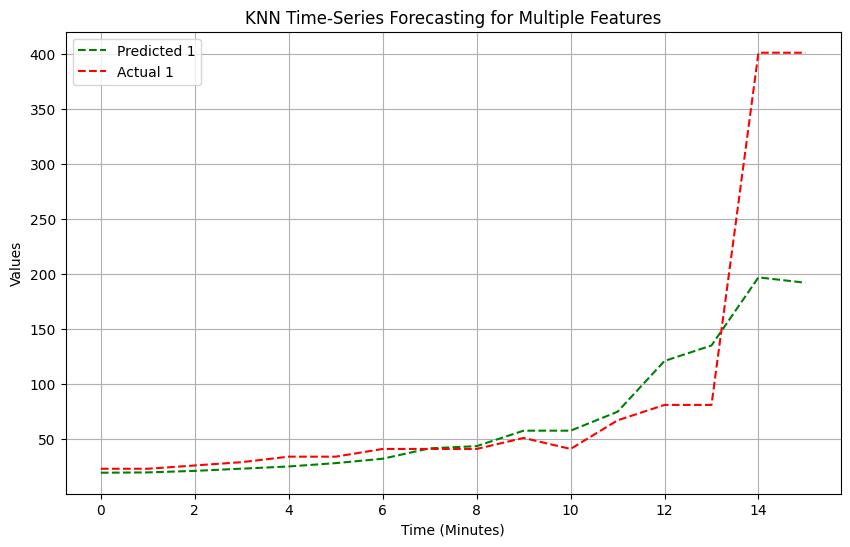

In [53]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(predicted_values.shape[0]), predicted_values[:, 0], label='Predicted 1', color='green', linestyle='--')
plt.plot(range(actual_values.shape[0]), actual_values[:, 0], label='Actual 1', color='red', linestyle='--')

plt.xlabel("Time (Minutes)")
plt.ylabel("Values")
plt.title("KNN Time-Series Forecasting for Multiple Features")
plt.legend()
plt.grid()
plt.show()

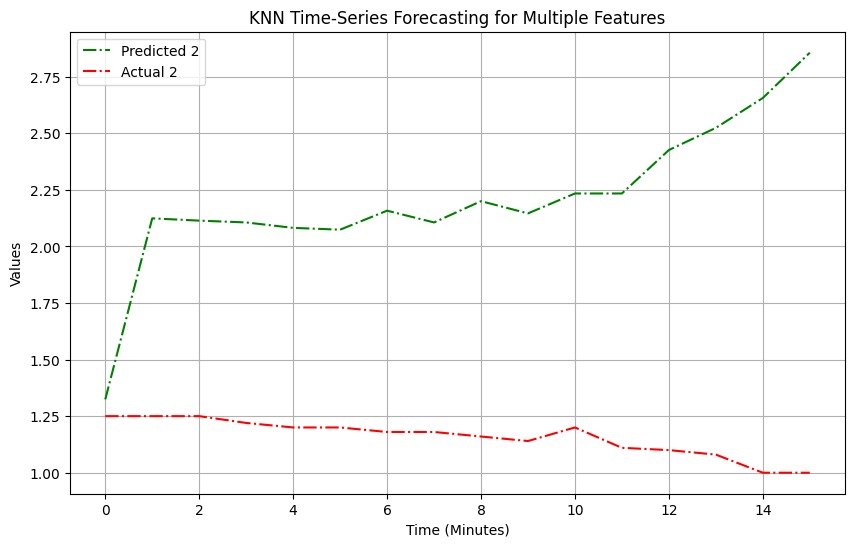

In [54]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(predicted_values.shape[0]), predicted_values[:, 1], label='Predicted 2', color='green', linestyle='-.')
plt.plot(range(actual_values.shape[0]), actual_values[:, 1], label='Actual 2', color='red', linestyle='-.')

plt.xlabel("Time (Minutes)")
plt.ylabel("Values")
plt.title("KNN Time-Series Forecasting for Multiple Features")
plt.legend()
plt.grid()
plt.show()

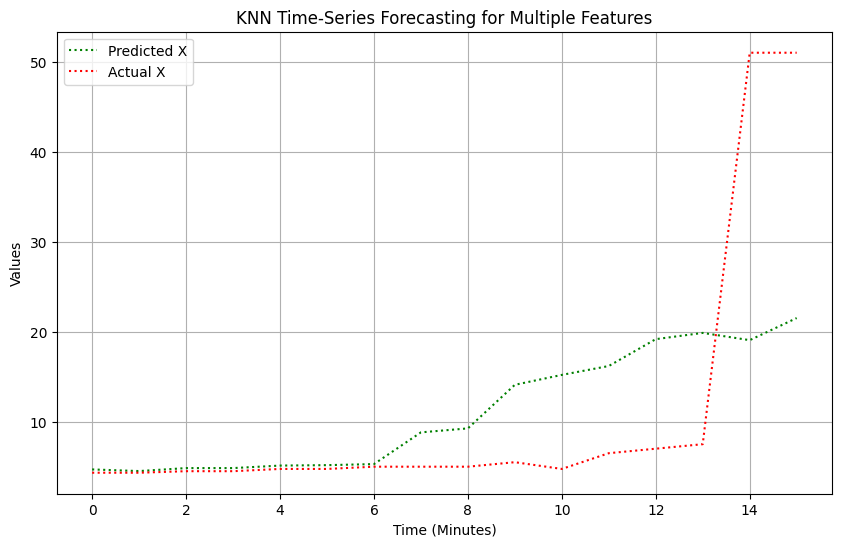

In [55]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(predicted_values.shape[0]), predicted_values[:, 2], label='Predicted X', color='green', linestyle=':')
plt.plot(range(actual_values.shape[0]), actual_values[:, 2], label='Actual X', color='red', linestyle=':')

plt.xlabel("Time (Minutes)")
plt.ylabel("Values")
plt.title("KNN Time-Series Forecasting for Multiple Features")
plt.legend()
plt.grid()
plt.show()

##### Future Model Predictions with KNN

In [135]:
# Reshape data for easier plotting
model_knn_data = training_data[training_data['fixture_id'].isin(unique_test_ids)]
model_knn_data.reset_index(inplace = True)
pred_df = pd.DataFrame(y_test_pred, columns=['class_0_pred', 'class_1_pred', 'class_2_pred'])
model_knn_data = pd.concat([model_knn_data, pred_df], axis=1)

In [136]:
model_knn_df_melted = model_knn_data[model_knn_data['match_minute']<95][['match_minute', 'class_0_pred', 'class_1_pred', 'class_2_pred']].melt(id_vars='match_minute', var_name='columns', value_name='values')

In [138]:
model_knn_data = model_knn_data[model_knn_data['match_minute'] <= 90][['fixture_id', 'match_minute', 'hf_1st-half', 'class_1_pred', 'class_2_pred', 'class_0_pred']]
model_knn_data = model_knn_data.sort_values(by=['fixture_id', 'match_minute', 'hf_1st-half'], ascending=[True, True, False])
model_knn_data = model_knn_data.drop_duplicates(subset=['fixture_id', 'match_minute'], keep='first')
model_knn_data.drop('hf_1st-half', axis='columns', inplace=True)

In [139]:
model_knn_data['fixture_id'].value_counts().quantile([0.03 , 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

0.03    46.6
0.10    67.0
0.25    79.0
0.50    85.0
0.75    87.0
0.90    89.0
0.95    90.0
Name: fixture_id, dtype: float64

In [140]:
fixture_counts = model_knn_data['fixture_id'].value_counts()
valid_fixture_ids = fixture_counts[fixture_counts >= 45].index
model_knn_data = model_knn_data[model_knn_data['fixture_id'].isin(valid_fixture_ids)]

In [141]:
all_minutes = pd.DataFrame({
    'match_minute': list(range(91))  # Minutes from 0 to 90
})

fixture_ids = model_knn_data['fixture_id'].unique()
model_knn_data_imputed = pd.MultiIndex.from_product([fixture_ids, all_minutes['match_minute']], names=['fixture_id', 'match_minute']).to_frame(index=False)

# Step 3: Merge the original DataFrame with the complete set of fixture_id-minute combinations
model_knn_data_imputed = pd.merge(model_knn_data_imputed, model_knn_data, on=['fixture_id', 'match_minute'], how='left')

# Step 4: Impute missing feature values (let's assume columns are 'feature1', 'feature2', 'feature3')
# We can use forward fill (or backward fill) for imputation based on the closest value
model_knn_data_imputed['class_1_pred'] = model_knn_data_imputed.groupby('fixture_id')['class_1_pred'].ffill().bfill()
model_knn_data_imputed['class_2_pred'] = model_knn_data_imputed.groupby('fixture_id')['class_2_pred'].ffill().bfill()
model_knn_data_imputed['class_0_pred'] = model_knn_data_imputed.groupby('fixture_id')['class_0_pred'].ffill().bfill()

model_knn_data_imputed = model_knn_data_imputed.sort_values(by=['fixture_id', 'match_minute'])

In [142]:
model_knn_train_data = model_knn_data_imputed[model_knn_data_imputed['fixture_id'].isin(fixture_ids[:70])]
model_knn_test_data = model_knn_data_imputed[model_knn_data_imputed['fixture_id'].isin(fixture_ids[70:])]

sequence_length = 91  # Time steps up to minute t
k = 5  # Number of nearest neighbors
features = ['class_1_pred', 'class_2_pred', 'class_0_pred']

In [143]:
def prepare_sequences(data, features, sequence_length):
    sequences = []
    for fixture_id in data['fixture_id'].unique():
        fixture_data = data[data['fixture_id'] == fixture_id]
        # Ensure we have all the required minutes (1-90)
        fixture_data = fixture_data.set_index('match_minute').reindex(range(0, 91)).reset_index()
        
        # Extract the sequence for the first 'sequence_length' minutes
        sequence = fixture_data[features].iloc[:sequence_length].values
        sequences.append((fixture_id, sequence))
    return sequences

In [144]:
model_pred_train_sequences = prepare_sequences(model_knn_train_data, features, sequence_length)
model_pred_test_sequences = prepare_sequences(model_knn_test_data, features, sequence_length)

In [145]:
# Define the KNN-based forecasting function with 3 features
def knn_forecast(train_sequences, observed_sequence, k, observed_sequence_length, features):
    """
    Perform KNN-based forecasting for a given observed sequence.
    
    Args:
        train_sequences (list): List of sequences for training data.
        observed_sequence (ndarray): Observed sequence up to time t.
        k (int): Number of nearest neighbors.
        observed_sequence_length (int): Length of the observed sequence.
        features (list): List of features to consider for distance computation.
        
    Returns:
        forecast (ndarray): Predicted future values.
    """
    # Calculate distances between observed_sequence and all training matches using multiple features
    observed_sequence = observed_sequence.reshape(1, -1)
    
    # Calculate the distance between the observed sequence and the training sequences
    train_sequences_array = np.array([seq[1].flatten() for seq in train_sequences])  # Flatten each sequence
    train_sequences_until_observed_t_array = train_sequences_array[:, :(observed_sequence_length*3)]
    distances = euclidean_distances(train_sequences_until_observed_t_array, observed_sequence.flatten().reshape(1, -1)).flatten()
    
    # Find the k-nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
    nearest_matches = [train_sequences[i] for i in nearest_indices]
    
    # Aggregate future values (e.g., mean) from nearest neighbors
    # Extract the future sequences for the nearest neighbors
    future_sequences = [train_sequences[i][1][observed_sequence_length:] for i in nearest_indices]
    forecast = np.mean(future_sequences, axis=0)  # Mean forecast for the future sequence
    
    return forecast


In [67]:
observed_sequence_length = 60

In [152]:
observed_sequence = model_pred_test_sequences[2][1][:observed_sequence_length, :]
model_pred_predicted_values = knn_forecast(model_pred_train_sequences, observed_sequence, k, observed_sequence_length, features)

In [153]:
# Compare to actual future values
model_pred_actual_values = model_pred_test_sequences[2][1][observed_sequence_length:]

Predicted Future Values: [[0.02803405 0.89414456 0.07782139]
 [0.0544141  0.77725626 0.16832964]
 [0.05378549 0.77555894 0.17065557]
 [0.05322318 0.7809198  0.16585702]
 [0.0285176  0.88213018 0.08935222]
 [0.02798082 0.88526799 0.0867512 ]
 [0.02810813 0.88679354 0.08509833]
 [0.02792141 0.88713998 0.08493861]
 [0.0274699  0.8898268  0.0827033 ]
 [0.02709083 0.89739096 0.07551821]
 [0.0270193  0.89328154 0.07969915]
 [0.0271576  0.89244202 0.08040038]
 [0.02743337 0.89291304 0.07965358]]
Actual Future Values: [[0.03922854 0.80926754 0.15150392]
 [0.03432177 0.83304073 0.1326375 ]
 [0.03544832 0.83364513 0.13090655]
 [0.03557804 0.8254493  0.13897265]
 [0.03557804 0.8254493  0.13897265]
 [0.03557804 0.8254493  0.13897265]
 [0.03511829 0.85121605 0.11366566]
 [0.03513987 0.8502147  0.11464543]
 [0.03513987 0.8502147  0.11464543]
 [0.0350917  0.85072539 0.11418291]
 [0.0350917  0.85072539 0.11418291]
 [0.03513551 0.85178738 0.11307712]
 [0.03594095 0.84383289 0.12022617]]


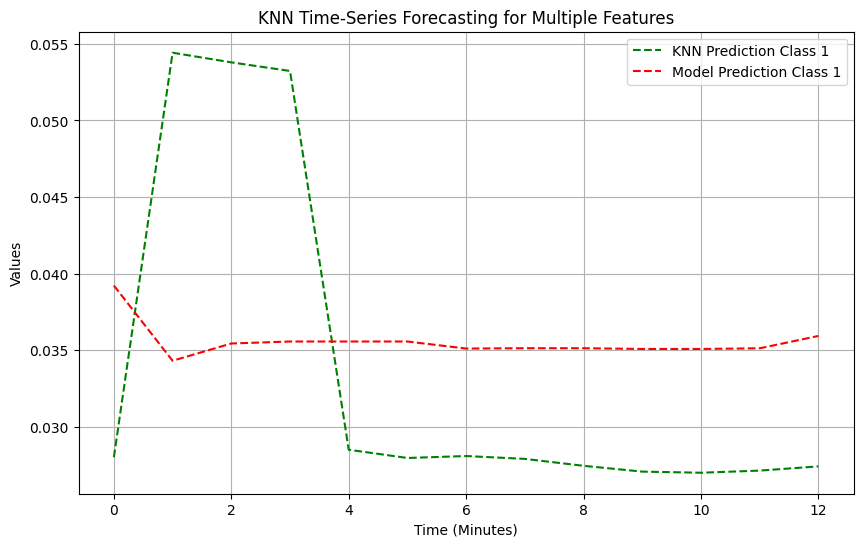

In [154]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(model_pred_predicted_values.shape[0]), model_pred_predicted_values[:, 0], label='KNN Prediction Class 1', color='green', linestyle='--')
plt.plot(range(model_pred_actual_values.shape[0]), model_pred_actual_values[:, 0], label='Model Prediction Class 1', color='red', linestyle='--')

plt.xlabel("Time (Minutes)")
plt.ylabel("Values")
plt.title("KNN Time-Series Forecasting for Multiple Features")
plt.legend()
plt.grid()
plt.show()

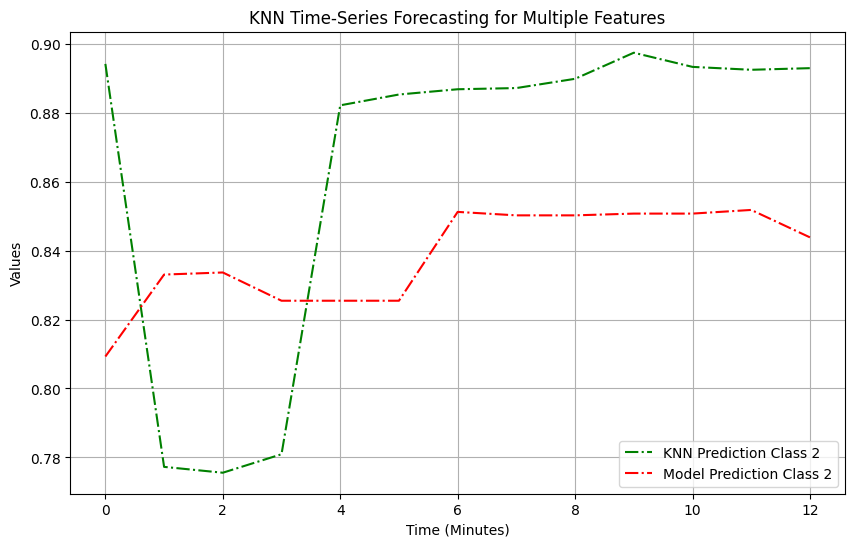

In [156]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(model_pred_predicted_values.shape[0]), model_pred_predicted_values[:, 1], label='KNN Prediction Class 2', color='green', linestyle='-.')
plt.plot(range(model_pred_actual_values.shape[0]), model_pred_actual_values[:, 1], label='Model Prediction Class 2', color='red', linestyle='-.')

plt.xlabel("Time (Minutes)")
plt.ylabel("Values")
plt.title("KNN Time-Series Forecasting for Multiple Features")
plt.legend()
plt.grid()
plt.show()

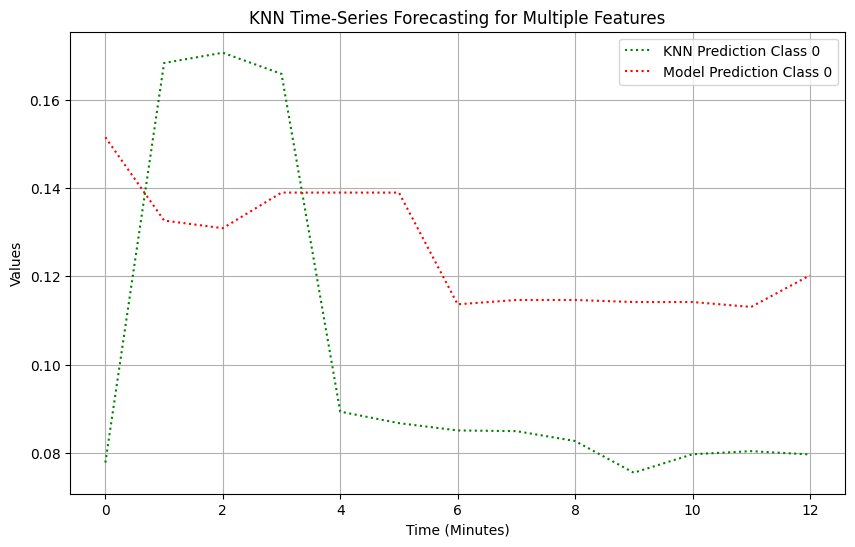

In [157]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(model_pred_predicted_values.shape[0]), model_pred_predicted_values[:, 2], label='KNN Prediction Class 0', color='green', linestyle=':')
plt.plot(range(model_pred_actual_values.shape[0]), model_pred_actual_values[:, 2], label='Model Prediction Class 0', color='red', linestyle=':')

plt.xlabel("Time (Minutes)")
plt.ylabel("Values")
plt.title("KNN Time-Series Forecasting for Multiple Features")
plt.legend()
plt.grid()
plt.show()

### Algorithm for Betting Strategy

1. **Dataset Splits**:

    - **Test Data**: Fixture IDs after '2024-11-01'.
    - **Model Training Data**: 70% of leftover fixture IDs.
    - **Model Validation Data**: 15% of leftover fixture IDs.
    - **Model Test Data**: 15% of leftover fixture IDs.
    - **Odd KNN Data**: All leftover fixture IDs.
    - **Model Prediction KNN Data**: Model Test Data.


2. **Simulation Process**:

    - For each match in Test Data:
        - Initialize simulation at minute 0.
        - Loop through each match minute (t) until the end of the match:
        
            1. **Calculate Profit per Class**:
                - For each class (Home Win, Draw, Away Win):
                  - Profit_c = Model Prediction_c × Odd_c

            2. **Forecast Future Minutes**:
                - Use Odd KNN and Model Prediction KNN outputs to forecast future odds and predictions.

            3. **Determine Maximum Profit**:
                - Identify the maximum profit for each class at minute (t):
                  - max_profit(t) = max(Profit_Home, Profit_Draw, Profit_Away)
                - Identify the overall maximum profit across all future minutes.

            4. **Betting Decision**:
                - If max_profit(t) is:
                    - Greater than future max_profit, and
                    - Greater than 1:
                        - Place Bet: Bet on the class with maximum profit at minute t.
                    - Otherwise:
                        - Do nothing.


3. **Result Evaluation**:

    - For each placed bet:
        - If the bet is successful:
          - Profit = Betted Odd - 1
        - If the bet fails:
          - Profit = -1
    - Aggregate all profits for performance evaluation.


4. **Output Summary**:

    - Generate two DataFrames:
        1. **Minute-wise Profit**:
            - Includes minute, class, profit, and maximum profit.
        2. **Betting Summary**:
            - Columns: Applied Minute, Betted Class, Betted Odd, Match Result Class, Profit.
    - Sum up all profits to assess overall strategy effectiveness.

In [327]:
simulation_data = training_data[training_data['split'] == 'simulation'][['fixture_id', 'match_minute', 'hf_1st-half', 'target', '1', '2', 'X', 'Goals - home', 'Goals - away']]
simulation_data = simulation_data.sort_values(by=['fixture_id', 'hf_1st-half', 'match_minute'], ascending=[True, False, True]).reset_index(drop = True)

simulation_data['goal_diff'] = simulation_data['Goals - home'] -  simulation_data['Goals - away']
sim_pred_df = pd.DataFrame(y_sim_pred, columns=['class_0_pred', 'class_1_pred', 'class_2_pred'])
simulation_data = pd.concat([simulation_data, sim_pred_df], axis=1)

simulation_data['class_0_profit'] = simulation_data['X'] * simulation_data['class_0_pred']
simulation_data['class_1_profit'] = simulation_data['1'] * simulation_data['class_1_pred']
simulation_data['class_2_profit'] = simulation_data['2'] * simulation_data['class_2_pred']

In [93]:
def prepare_sequences(data, features, sequence_length):
    sequences = []
    for fixture_id in data['fixture_id'].unique():
        fixture_data = data[data['fixture_id'] == fixture_id]
        # Ensure we have all the required minutes (1-90)
        fixture_data = fixture_data.set_index('match_minute').reindex(range(0, 91)).reset_index()
        
        # Extract the sequence for the first 'sequence_length' minutes
        sequence = fixture_data[features].iloc[:sequence_length].values
        sequences.append((fixture_id, sequence))
    return sequences

sequence_length = 91  # Time steps up to minute t
k = 5  # Number of nearest neighbors
odd_features = ['X', '1', '2']
model_pred_features = ['class_0_pred', 'class_1_pred', 'class_2_pred']

odd_train_sequences = prepare_sequences(odd_knn_data_imputed, odd_features, sequence_length)
model_pred_train_sequences = prepare_sequences(model_knn_data_imputed, model_pred_features, sequence_length)

In [95]:
# Define the KNN-based forecasting function with 3 features
def knn_forecast(train_sequences, observed_sequence, k, observed_sequence_length, features):
    """
    Perform KNN-based forecasting for a given observed sequence.
    
    Args:
        train_sequences (list): List of sequences for training data.
        observed_sequence (ndarray): Observed sequence up to time t.
        k (int): Number of nearest neighbors.
        observed_sequence_length (int): Length of the observed sequence.
        features (list): List of features to consider for distance computation.
        
    Returns:
        forecast (ndarray): Predicted future values.
    """
    # Calculate distances between observed_sequence and all training matches using multiple features
    observed_sequence = observed_sequence.reshape(1, -1)
    
    # Calculate the distance between the observed sequence and the training sequences
    train_sequences_array = np.array([seq[1].flatten() for seq in train_sequences])  # Flatten each sequence
    train_sequences_until_observed_t_array = train_sequences_array[:, :(observed_sequence_length*3)]
    distances = euclidean_distances(train_sequences_until_observed_t_array, observed_sequence.flatten().reshape(1, -1)).flatten()
    
    # Find the k-nearest neighbors
    nearest_indices = np.argsort(distances)[:k]
    nearest_matches = [train_sequences[i] for i in nearest_indices]
    
    # Aggregate future values (e.g., mean) from nearest neighbors
    # Extract the future sequences for the nearest neighbors
    future_sequences = [train_sequences[i][1][observed_sequence_length:] for i in nearest_indices]
    forecast = np.mean(future_sequences, axis=0)  # Mean forecast for the future sequence
    
    return forecast


In [210]:
odd_features = ['X', '1', '2']
model_pred_features = ['class_0_pred', 'class_1_pred', 'class_2_pred']
k = 5

column_names = ['fixture_id', 'real_match_minute', 'match_minute', 'X', '1', '2', 'class_0_pred', 'class_1_pred', 'class_2_pred']
fixture_minute_class_df = pd.DataFrame(columns=column_names)
for fixture in simulation_data['fixture_id'].unique():
    fixture_data = simulation_data[simulation_data['fixture_id'] == fixture]               
    for index, row in fixture_data.iterrows():
        real_match_minute = row['match_minute']
        observed_data = fixture_data[(fixture_data['match_minute'] <= real_match_minute) & (fixture_data['hf_1st-half'] >= row['hf_1st-half'])]
        observed_sequence_length = len(observed_data)
        odd_observed_sequence = observed_data[['X', '1', '2']].to_numpy()
        model_pred_observed_sequence = observed_data[['class_0_pred', 'class_1_pred', 'class_2_pred']].to_numpy()
        
        if observed_sequence_length < 90:
            odd_predicted_values = knn_forecast(odd_train_sequences, odd_observed_sequence, k, observed_sequence_length, odd_features)
            model_pred_predicted_values = knn_forecast(model_pred_train_sequences, model_pred_observed_sequence, k, observed_sequence_length, model_pred_features)
            odd_decision_array = np.vstack((odd_observed_sequence[-1:, :], odd_predicted_values))
            model_pred_decision_array = np.vstack((model_pred_observed_sequence[-1:, :], model_pred_predicted_values))
        else:
            odd_decision_array = odd_observed_sequence[-1:, :]
            model_pred_decision_array = model_pred_observed_sequence[-1:, :]

        # Append result using numpy/pandas without concatenation
        decision_data = {
            'X': odd_decision_array[:, 0],
            '1': odd_decision_array[:, 1],
            '2': odd_decision_array[:, 2],
            'match_minute': real_match_minute + np.arange(odd_decision_array.shape[0]),
            'class_0_pred': model_pred_decision_array[:, 0],
            'class_1_pred': model_pred_decision_array[:, 1],
            'class_2_pred': model_pred_decision_array[:, 2],
            'real_match_minute': real_match_minute,
            'fixture_id': fixture
        }
        decision_df = pd.DataFrame(decision_data)
        decision_df = decision_df[column_names]
        fixture_minute_class_df = pd.concat([fixture_minute_class_df, decision_df], ignore_index=True)

In [281]:
fixture_minute_class_df.to_csv('fixture_minute_class_df.csv', index=False)

In [452]:
fixture_minute_class_df = pd.read_csv('fixture_minute_class_df.csv')

In [453]:
fixture_minute_df = simulation_data.drop_duplicates(subset=['fixture_id', 'match_minute','hf_1st-half',], keep='first')

fixture_minute_df = fixture_minute_df[['fixture_id', 'match_minute', 'goal_diff']]
fixture_minute_df = fixture_minute_df.rename(columns={'match_minute': 'real_match_minute'})

fixture_minute_class_df = pd.merge(fixture_minute_class_df, fixture_minute_df, on=['fixture_id', 'real_match_minute'], how='left')

In [454]:
fixture_minute_class_df['class_0_pred'] = fixture_minute_class_df['class_0_pred'].astype(float)
fixture_minute_class_df['class_1_pred'] = fixture_minute_class_df['class_1_pred'].astype(float)
fixture_minute_class_df['class_2_pred'] = fixture_minute_class_df['class_2_pred'].astype(float)

fixture_minute_class_df['model_decision'] = fixture_minute_class_df[['class_0_pred', 'class_1_pred', 'class_2_pred']].idxmax(axis=1)

In [455]:
def calculate_profit(row):
    if row['model_decision'] == 'class_0_pred':
        return row['class_0_pred'] * row['X']
    elif row['model_decision'] == 'class_1_pred':
        return row['class_1_pred'] * row['1']
    elif row['model_decision'] == 'class_2_pred':
        return row['class_2_pred'] * row['2']
fixture_minute_class_df['profit'] = fixture_minute_class_df.apply(calculate_profit, axis=1)

In [456]:
fixture_minute_grouped_df = fixture_minute_class_df.groupby(['fixture_id', 'real_match_minute'])
max_profit_indices = fixture_minute_grouped_df['profit'].idxmax()
max_profit_rows = fixture_minute_class_df.loc[max_profit_indices]
fixture_max_profit_df = max_profit_rows.reset_index(drop=True)

In [457]:
bettable_fixture_minutes = fixture_max_profit_df[fixture_max_profit_df['real_match_minute'] == fixture_max_profit_df['match_minute']].reset_index(drop = True)
bettable_fixture_minutes['real_match_minute'] = pd.to_numeric(bettable_fixture_minutes['real_match_minute'], errors='coerce')

#### **No-Bet Strategy for Draws**

- Based on AUC values, draw outcomes are less predictable compared to home or away wins.

- To minimize risks and avoid low-confidence decisions, a **no-bet strategy** is implemented for scenarios where the model predicts a draw outcome (`class_0_pred`).


#### **No-Bet Strategy for Potential Risks**

- Football is highly dynamic, and a single goal can drastically alter the outcome of a match.


- If there is a **high risk of a goal affecting the bet** (e.g., close margins in probabilities), the **no-bet strategy** is applied to avoid false betting and potential losses.

---

#### **Betting Success Check Logic**

The logic determines whether a placed bet was successful based on the model’s decision and the actual match outcome (`target`):

1. **`successful_bet_check` Function**:
   
   - The function compares the model's decision (`model_decision`) to the actual result (`target`):
     
     - If the model decision matches the actual result (e.g., predicted home win and the result is home win), the bet is marked as successful (`1`).
     
     - Otherwise, the bet is marked as unsuccessful (`0`).
---

#### **Profit Calculation Logic**

The profit is calculated based on whether the bet was successful and the associated betting odds:

1. **`calculate_final_profit` Function**:
   
   - If the bet was successful:
   
       - Profit is calculated as the **betting odd minus 1** (e.g., if the odd is 2.5, the profit is `2.5 - 1 = 1.5`).
   
   - If the bet was unsuccessful:
     
     - A loss of `-1` is assigned.
---

#### **Workflow Summary**

1. **Mark Successful Bets**:
   - Apply the `successful_bet_check` function to each row of the `betted_fixture_minutes` DataFrame to identify whether the bet succeeded.


2. **Calculate Profits**:

    - Use the `calculate_final_profit` function to calculate the profit or loss for each bet based on the betting odds and the success of the bet.


3. **Final DataFrame**:

    - The updated `betted_fixture_minutes` DataFrame includes:
    
        - `successful_bet`: Indicates whether the bet succeeded (`1` for success, `0` for failure).
     
        - `final_profit`: The profit or loss for the bet.

---


In [458]:
def bet_logic(row):
    if (row['model_decision'] == 'class_0_pred'):
        return 0
    elif (row['model_decision'] == 'class_1_pred') & (row['goal_diff'] > 1):
        return 1
    elif (row['model_decision'] == 'class_2_pred') & (row['goal_diff'] < -1):
        return 1
    else:
        return 0
bettable_fixture_minutes['bettable_logic'] = bettable_fixture_minutes.apply(bet_logic, axis=1)
bettable_fixture_minutes = bettable_fixture_minutes[bettable_fixture_minutes['bettable_logic'] == 1]

In [459]:
fixture_grouped_df = bettable_fixture_minutes.groupby('fixture_id')
min_match_minute_indices = fixture_grouped_df['real_match_minute'].idxmin()
min_match_minute_rows = bettable_fixture_minutes.loc[min_match_minute_indices]
betted_fixture_minutes = min_match_minute_rows.reset_index(drop=True)

In [460]:
target_fixture_id_df = simulation_data[['fixture_id', 'target']].drop_duplicates(subset='fixture_id', keep='first')

In [461]:
betted_fixture_minutes = pd.merge(betted_fixture_minutes, target_fixture_id_df, on='fixture_id', how='left')

In [462]:
def successful_bet_check(row):
    if (row['model_decision'] == 'class_0_pred') & (row['target'] == 0):
        return 1
    elif (row['model_decision'] == 'class_1_pred') & (row['target'] == 1):
        return 1
    elif (row['model_decision'] == 'class_2_pred') & (row['target'] == 2):
        return 1
    else:
        return 0
betted_fixture_minutes['successful_bet'] = betted_fixture_minutes.apply(successful_bet_check, axis=1)

In [463]:
def calculate_final_profit(row):
    if (row['model_decision'] == 'class_0_pred') & (row['successful_bet'] == 1):
        return row['X'] - 1
    elif (row['model_decision'] == 'class_1_pred') & (row['successful_bet'] == 1):
        return row['1'] - 1
    elif (row['model_decision'] == 'class_2_pred') & (row['successful_bet'] == 1):
        return row['2'] - 1
    else:
        return -1
betted_fixture_minutes['final_profit'] = betted_fixture_minutes.apply(calculate_final_profit, axis=1)

In [464]:
betted_fixture_minutes['final_profit'].sum()

0.6900000000000004

In [465]:
betted_fixture_minutes[betted_fixture_minutes['successful_bet'] == 0]

Empty DataFrame
Columns: [fixture_id, real_match_minute, match_minute, X, 1, 2, class_0_pred, class_1_pred, class_2_pred, model_decision, profit, goal_diff, bettable_logic, target, successful_bet, final_profit]
Index: []

In [466]:
betted_fixture_minutes[betted_fixture_minutes['successful_bet'] == 1]

fixture_id  real_match_minute  match_minute     X       1       2  \
0   19134536.0               83.0          83.0  10.0   81.00    1.06   
1   19134537.0               87.0          87.0  51.0    1.00  451.00   
2   19134538.0               58.0          58.0  21.0    1.01   67.00   
3   19134539.0               83.0          83.0  26.0  101.00    1.01   
4   19134542.0               56.0          56.0  13.0    1.04   41.00   
5   19134869.0               69.0          69.0   8.0    1.11   23.00   
6   19134875.0               79.0          79.0  41.0    1.00  351.00   
7   19134877.0               82.0          82.0  23.0    1.01   81.00   
8   19135363.0               73.0          73.0  26.0    1.00  101.00   
9   19135368.0               78.0          78.0  26.0  101.00    1.01   
10  19135369.0               80.0          80.0  41.0    1.00  301.00   
11  19135377.0               42.0          42.0   8.5    1.11   26.00   
12  19135378.0               67.0          67.0  23.0   51.00    1.01   
13  19139733.0               72.0          72.0  26.0    1.01   67.00   
14  19139739.0               80.0          80.0  21.0    1.01   67.00   
15  19139742.0               81.0          81.0  13.0   41.00    1.04   
16  19139744.0               87.0          87.0  41.0    1.00  351.00   
17  19139748.0               80.0          80.0  21.0   81.00    1.01   
18  19154620.0               42.0          42.0  29.0    1.00   51.00   
19  19154624.0               13.0          13.0   7.5    1.16   13.00   
20  19154626.0               64.0          64.0  23.0   51.00    1.01   
21  19154631.0               57.0          57.0  17.0    1.03   41.00   
22  19155173.0               76.0          76.0  17.0   51.00    1.02   
23  19155176.0               80.0          80.0  29.0  101.00    1.00   
24  19155185.0               80.0          80.0  21.0   81.00    1.01   
25  19172100.0               90.0          90.0  21.0   81.00    1.01   
26  19172103.0               83.0          83.0  34.0    1.00  151.00   
27  19172110.0               87.0          87.0  51.0    1.00  351.00   
28  19172112.0               90.0          90.0  51.0    1.00  451.00   
29  19172117.0               56.0          56.0  26.0    1.01   67.00   

    class_0_pred  class_1_pred  class_2_pred model_decision    profit  \
0       0.245411      0.034277      0.720311   class_2_pred  0.763530   
1       0.080464      0.875114      0.044423   class_1_pred  0.875114   
2       0.082041      0.890030      0.027929   class_1_pred  0.898930   
3       0.120343      0.043305      0.836352   class_2_pred  0.844715   
4       0.058626      0.911124      0.030250   class_1_pred  0.947568   
5       0.086230      0.878795      0.034974   class_1_pred  0.975463   
6       0.045578      0.929446      0.024976   class_1_pred  0.929446   
7       0.058426      0.910243      0.031331   class_1_pred  0.919346   
8       0.040841      0.936450      0.022710   class_1_pred  0.936450   
9       0.060498      0.025777      0.913725   class_2_pred  0.922862   
10      0.033836      0.938218      0.027946   class_1_pred  0.938218   
11      0.093233      0.871658      0.035109   class_1_pred  0.967541   
12      0.086316      0.062980      0.850704   class_2_pred  0.859211   
13      0.037159      0.942621      0.020219   class_1_pred  0.952048   
14      0.059617      0.911456      0.028927   class_1_pred  0.920571   
15      0.192852      0.088031      0.719118   class_2_pred  0.747882   
16      0.061725      0.910276      0.027999   class_1_pred  0.910276   
17      0.064195      0.055355      0.880451   class_2_pred  0.889255   
18      0.043563      0.926712      0.029724   class_1_pred  0.926712   
19      0.088195      0.839057      0.072748   class_1_pred  0.973306   
20      0.084444      0.067836      0.847720   class_2_pred  0.856197   
21      0.044908      0.923436      0.031656   class_1_pred  0.951139   
22      0.104814      0.031463      0.863723   class_2_pred  

###  4. Results :

The final profit from the implemented betting strategy amounts to **0.69 units**, representing a **2.3% return on investment (ROI).** This result is based on the assumption that *1 unit is bet per match*, with a total of 30 matches considered for betting. 

While the return is modest and indicates potential, it also highlights that significant improvements are needed. The strategy, built on simulations, KNN-based forecasting, and basic risk mitigation, shows the capability to make informed decisions. However, there is substantial room for enhancement to better optimize profits and reduce risks.


###  5. Future Work :

**1. Optimal Betting Amount Strategy**

Instead of betting a fixed amount (1 unit) per match, future work can explore strategies for determining the optimal bet size based on:

- Predicted probabilities for each outcome 

- Risk tolerance levels

- Odds and expected profits

This approach could help maximize ROI while managing exposure to losses effectively.

**2. Enhanced Feature Engineering**

Additional features can be designed to better capture the dynamics of draw cases, where predictions tend to be less confident. 

For example:

- Momentum Indicators: Tracking the change in odds or predictions over time for draw scenarios.

- Event-Based Features: Incorporating live match events, such as yellow cards or substitutions, which might impact draw probabilities.

- Contextual Features: Using league or team-specific statistics to better understand the likelihood of low-scoring games, which are more prone to ending in draws.

**3. Dynamic Strategy Testing**

- Incorporating real-time testing with live data to validate the strategy under actual betting conditions.

- Exploring adaptive strategies that adjust based on live odds or significant game events, improving the robustness of the approach.

